# Autoencoder

En general, nos encontraremos con conjuntos de datos que contienen un montón de carácteristicas `features`
que hacen muy complicados los cálculos. Sin embargo, podriamos estar interesados en las partes de los
datos que más contribuyen al aprendizaje de un modelo, lo qeu conduce a menos cálculos. El proceso de elegir
las partes más importantes de los datos se conoce como selección de carácteristicas `feature selection`, que se
puede hacer con un **autoencoder**.

Pero ¿qué hace exactamente un **autoencoder**?. Primero es un `red neuronal`, que en lugar de encontrar la función que mapea las features **x** a values o labels **y**, mapea a **x** en si mismo **x**. Pero, ¿para qué queremos eso?

Veamos un gráfico
![Creado con NN-SVG](./autoencoder.png "Creado con NN-SVG")

Vemos que el autoencoder consiste de dos partes: el **encoder**, que aprende la representación de los datos,
es decir, las features *importantes* **z** de los datos; y el **decoder** que reconstruye los datos basado en 
**z** y como fue estructurado.

Matemáticamente, se escribe como
$$ z = f(h_e(x))$$

z es la representación del dato aprendido por el *encoder* del input *x*.

$$ \hat{x} = f(h_d(z))$$

$\hat{x}$ es el dato reconstruido por el *decoder* basado en la representación aprendida *z*.

Como discutimos arriba, la salida del encoder es la entrada del decoder. ¿Eso es todo? No, no exactamente.
El punto se encuentra en que solo hemos hablado de los componentes del un *autoencoder*, pero no de **como aprender** realmente. Hasta aquí, solo conocemos el flujo de los datos. 

Como otras redes neuronales, un autoencoder aprender a través de **backpropagation**. Pero, en lugar de comparar los values o labels, compara el *dato reconstruido* $\hat{x}$ y el original $x$. A esta comparación la llamamos **función de error de reconstrucción**, y viene dada por la ecuación
$$
L = \frac{1}{n} \sum^{n-1}_{i=0} \left(\hat{x}_i - x_i\right)^2
$$


Ahora implementemos un ejemplo.

In [1]:
# Como siempre importamos lo necesario
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import utils


class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

Expliquemos algunas cosas:
* `torch.nn.Linear` crea un función lineal ($\theta x + b$), por defecto, parámetros distribuidos [He/Kaiming uniform](https://arxiv.org/abs/1502.01852). Esto significa que tendremos activacion no lineales en esas capas.
* `in_features` da el tamaño del tensor de entrada de una capa en particular, por ejemplo, en `self.encoder_hidden_layer`, acepta un tensor de entrada con tamaño `[N, input_shape]` donde `N` es el número de ejemplos, y `input_shape` es el número de features en un ejemplo.
* `out_features` da el tamaño del tensor de salida. Por lo tanto, `self.decoder_output_layer` el tamaño de la feature es `kwargs["input_shape"]`, lo que indica que reconstruye la entrada de datos.
* `forward` define la secuencia para un modelo.

Instanciemos nuestra clase `AE`

In [2]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Probaremos nuestro autoencoder con nuestra base de datos de cabecera, MNIST.

In [3]:
#clase de torchvision que concatena transformaciones en este caso ToTensor(es obvio) y Normalize(Normaliza un tensor de imagen a una media y desviación )
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))])
# descargamos el dataset MNIST, lo marcamos como entrenador y aplicamos las transformaciones
train_dataset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# descargamos el dataset, lo marcamos como no entrenador
test_dataset = datasets.MNIST('MNIST_data', train=False, transform=transform, download=True)

# Generamos un iterador de Torch que suporta todas las operaciones de la libreria.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True) 
#batch_size cuantas muestras por lote serán cargadas (default = 1)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Ahora entrenemos al autoencoder.

In [4]:
epochs = 20
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.909253
epoch : 2/20, loss = 0.895383
epoch : 3/20, loss = 0.892723
epoch : 4/20, loss = 0.891572
epoch : 5/20, loss = 0.891031
epoch : 6/20, loss = 0.890781
epoch : 7/20, loss = 0.890642
epoch : 8/20, loss = 0.890539
epoch : 9/20, loss = 0.890377
epoch : 10/20, loss = 0.890239
epoch : 11/20, loss = 0.890173
epoch : 12/20, loss = 0.890129
epoch : 13/20, loss = 0.890074
epoch : 14/20, loss = 0.890033
epoch : 15/20, loss = 0.889978
epoch : 16/20, loss = 0.889950
epoch : 17/20, loss = 0.889900
epoch : 18/20, loss = 0.889880
epoch : 19/20, loss = 0.889833
epoch : 20/20, loss = 0.889804


Vemos los resultados.

In [5]:
images, labels = next(iter(train_loader))
image = images.view(-1,784)
# Apagamos lo gradientes porque es una prueba
with torch.no_grad():
    recon = model(image)

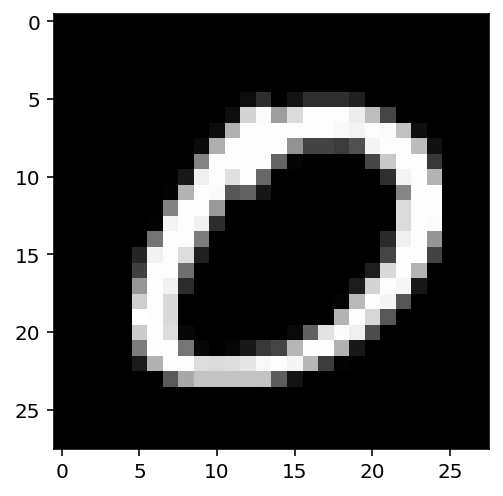

In [6]:
plt.imshow(image[1].view(-1,28).numpy().squeeze(), cmap='gray')

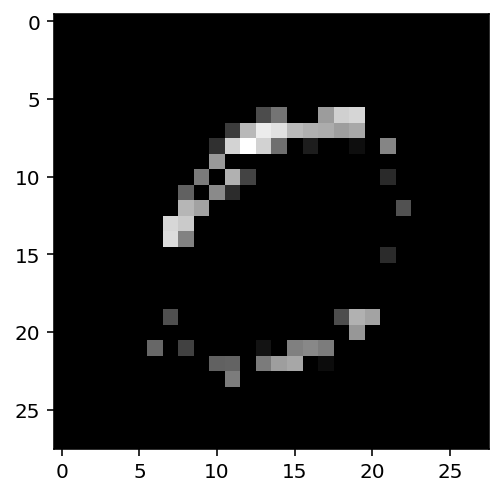

In [7]:
plt.imshow(recon[1].view(-1,28).numpy().squeeze(), cmap='gray')